### Domain Adversarial Neural Networks

We explore here the insigths of learning during the Domain Adapation step in DANN architecture. The work is based on: [this](https://nbviewer.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/tutorial6-TL_DA.ipynb)

In [189]:
# General setup
import os
import sys
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.manifold import TSNE

# PyTorch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as tvtf
from torchvision.utils import make_grid
from torch.autograd import Function
import torch.utils.data as data

# Plot display, data and devices
%matplotlib inline
sns.set()
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current device: {}'.format(device))

# Set random seed
torch.manual_seed(0)
np.random.seed(0)

The current device: cuda


In [96]:
# Plot utils
def show(img, ax=None):
    npimg = img.cpu().numpy()
    if ax is None:
        ax = plt
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

#### Datasets setup

- Source domain: MNIST
- Target domain: MNISTM


In [97]:
class MNISTMDataset(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [98]:
image_size = 28
batch_size = 4

data_dir = "./data/"

# Transformations
tf_source = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,)) # classical std and mean for MNIST
])

tf_target = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


In [99]:
# MNIST
ds_source = tv.datasets.MNIST(root= data_dir + "mnist", train=True, transform=tf_source, download=True)
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)

In [100]:
ds_target = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)

dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

In [256]:
# Extracting some samples for later plot
num_samples = 1000
rand_samples_indexes = np.random.randint(1, min(len(ds_source), len(ds_target)), num_samples)

mnist_samples = [
    ds_source[random_index][0] for random_index in rand_samples_indexes
]
mnistm_samples = [
    ds_target[random_index][0] for random_index in rand_samples_indexes
]

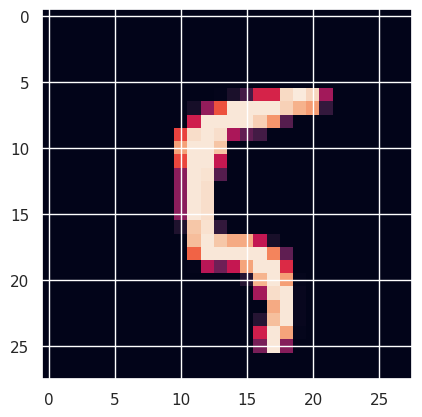

In [101]:
# Plot some images from these datasets
mnist_sample = ds_source[100][0]
show(mnist_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 3


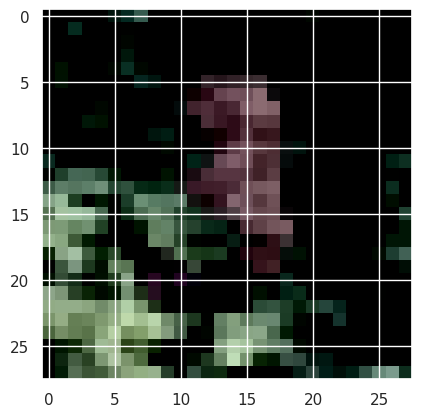

In [102]:
mnistm_sample, label = ds_target[10]
print("Label: {}".format(label))
show(mnistm_sample)

In [103]:

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [126]:
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), 
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), 
            nn.Dropout(), 
            nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), 
            nn.BatchNorm1d(100), 
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )
    
    def extract_features(self, x: torch.Tensor) -> torch.Tensor:
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        features = features.detach().cpu()
        return features
    
    def forward(self, x, grl_lambda=1.0):
        # print('Input shape', x.shape)
        
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

In [248]:
model = DACNN()
lr = 1e-3
n_epochs = 1

# Setup optimizer as usual
optimizer = optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

# Device
model = model.to(device)

In [249]:
# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target)) // 8
max_batches

1843

In [250]:
for epoch_idx in range(n_epochs):
    
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)
    
    for batch_idx in tqdm(range(max_batches), total=max_batches, desc='Iterating...'):
        optimizer.zero_grad()
        
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        X_s = X_s.to(device)
        y_s = y_s.to(device)
        
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels
        y_s_domain = y_s_domain.to(device)
        
        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels
        
        X_t = X_t.to(device)
        y_t_domain = y_t_domain.to(device)
        
        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
    print(
        'Epoch {}: Target domain loss: {} | Source domain loss: {} | Source class loss: {}'.format(
            epoch_idx,
            loss_t_domain,
            loss_s_domain,
            loss_s_label
        )
    )
    

    # Save the model
model = model.to('cpu')
PATH = './models/dacnn_{}_{}_max_batches_{}.pth'.format(n_epochs, lr, max_batches)
torch.save(model.state_dict(), PATH)

Epoch 0001 / 0001


Iterating...: 100%|████████████████████████████████████████████████████████████| 1843/1843 [00:16<00:00, 109.73it/s]

Epoch 0: Target domain loss: 0.6801201105117798 | Source domain loss: 0.6426331996917725 | Source class loss: 0.9981704950332642


In [266]:
no_adapt_model = DACNN()
no_adapt_model.load_state_dict(torch.load('./models/dacnn_1_0.001_max_batches_1843.pth'))

small_model = DACNN()
small_model.load_state_dict(torch.load('./models/dacnn_10_0.001_max_batches_1843.pth'))

large_model = DACNN()
large_model.load_state_dict(torch.load('./models/dacnn_20_0.001_max_batches_1843.pth'))

<All keys matched successfully>

In [267]:
# Test the model with one sample
print("Input shape: {}".format(mnist_sample.shape))
cls, dom = model(mnistm_sample)

Input shape: torch.Size([1, 28, 28])


In [268]:
cls.shape

torch.Size([3, 10])

In [269]:
cls = torch.sum(cls, dim=0)
_, class_prediction = torch.max(cls, dim=0)

In [270]:
class_prediction

tensor(8)

In [271]:
dom = torch.sum(dom, dim=0)
_, domain_prediction = torch.max(dom, dim=0)
domain_prediction

tensor(0)

### Vizualizing the overlapping of the two domains

In [272]:
# Extract features from the latent space of the feature extractor
def latent_space(model: DACNN) -> tuple[np.ndarray, np.ndarray]:
    
    mnist_sample_features = np.array([
        model.extract_features(sample) for sample in mnist_samples
    ])


    mnist_sample_features = np.array([
        sample.reshape(
            sample.shape[0] * sample.shape[1]
        )
        for sample in mnist_sample_features
    ])


    mnistm_sample_features = np.array([
        model.extract_features(sample) for sample in mnistm_samples
    ])


    mnistm_sample_features = np.array([
        sample.reshape(
            sample.shape[0] * sample.shape[1]
        )
        for sample in mnistm_sample_features
    ])
    
    # Extract top meaningful features from feature extractor
    
    mnist_sample_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=True).fit_transform(mnist_sample_features)
    mnistm_sample_features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=True).fit_transform(mnistm_sample_features)
    
    return mnist_sample_features, mnistm_sample_features


[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.798514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.436897
[t-SNE] KL divergence after 1000 iterations: 1.033609
[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.783769
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.121223
[t-SNE] KL divergence after 1000 iterations: 1.449977


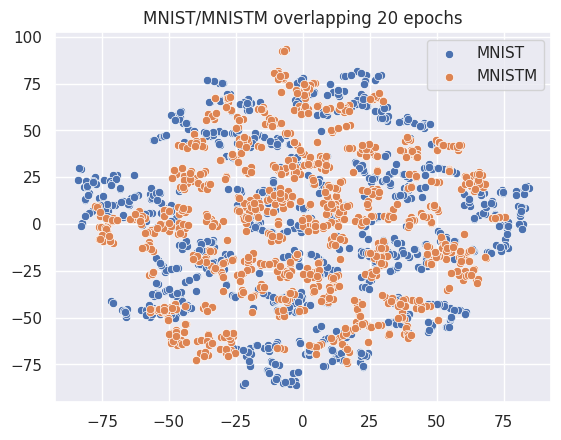

In [275]:
mnist_sample_features, mnistm_sample_features = latent_space(large_model)

m = sns.scatterplot(x = mnist_sample_features[:, 0], 
                y = mnist_sample_features[: ,1],
               )
mm = sns.scatterplot(x = mnistm_sample_features[:, 0], 
                y = mnistm_sample_features[: ,1],
)

plt.title('MNIST/MNISTM overlapping 20 epochs')
plt.legend(loc='best', labels=['MNIST', 'MNISTM'])
plt.show(mm)